In [7]:
!pip install requests beautifulsoup4 nltk spacy scikit-learn rake-nltk
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Extraction Code**

In [19]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

def fetch_article_content(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    # Extract text from <p> tags
    paragraphs = soup.find_all('p')
    article_text = ' '.join([para.get_text() for para in paragraphs])
    return article_text

def preprocess_text(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def tfidf_keywords(texts, top_n=10):
    # Create TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_df=1, min_df=0.5, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    # Extract top N keywords for each document
    keywords = []
    for doc in range(tfidf_matrix.shape[0]):
        tfidf_scores = zip(feature_names, tfidf_matrix[doc].toarray().flatten())
        sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords = [word for word, score in sorted_scores[:top_n]]
        keywords.append(top_keywords)
    return keywords

def textrank_keywords(text, top_n=10):
    doc = nlp(text)
    # Extract candidate phrases
    candidate_phrases = [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) > 1]  # Filter single-word phrases
    # Calculate word frequencies
    word_freq = Counter(candidate_phrases)
    # Select top N keywords
    top_keywords = [word for word, freq in word_freq.most_common(top_n)]
    return top_keywords

def save_keywords_to_file(keywords, filename="keywords.txt"):
    with open(filename, 'w') as file:
        for keyword_list in keywords:
            file.write(", ".join(keyword_list) + "\n")

def download_file(file_path):
    from google.colab import files
    files.download(file_path)

# Example Usage
if __name__ == "__main__":
    # URL of the article
    url = "https://aerospace.honeywell.com/us/en/about-us/blogs/in-search-of-artificial-intelligence-and-better-outcomes?utm_source=google&utm_medium=cpc&utm_campaign=23-aero-ww-dsa-blogs&utm_content=dyn-en-lp&gad_source=1&gclid=CjwKCAjwps-zBhAiEiwALwsVYVDcAs1je7oyQrYf0yofFvLKPiJjSNXQ3BYujjC-9l6YDu2bbmhF2BoCUGAQAvD_BwE"

    # Fetch article content
    article_text = fetch_article_content(url)

    # Preprocess text
    processed_text = ' '.join(preprocess_text(article_text))

    # Extract keywords using TF-IDF
    tfidf_results = tfidf_keywords([processed_text])
    print("TF-IDF Keywords:")
    for i, keywords in enumerate(tfidf_results):
        print(f"Document {i+1}: {keywords}")

    # Extract keywords using TextRank
    print("\nTextRank Keywords:")
    textrank_results = textrank_keywords(article_text)
    print(f"Document: {textrank_results}")

    # Save all keywords to file
    all_keywords = [tfidf_results[0], textrank_results]
    save_keywords_to_file(all_keywords)

    # Download the file
    download_file("keywords.txt")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TF-IDF Keywords:
Document 1: ['learning', 'data', 'airlines', 'deep', 'use', 'ai', 'fuel', 'ground', 'systems', 'aerospace']

TextRank Keywords:
Document: ['Deep Learning', 'artificial intelligence', ' \n                        North America', 'Latin America\n                        \n\n \n                        Asia Pacific', 'the account number', 'your parts', 'shopping cart', 'Your current cart', 'North America\n                        \n\n \n                        Latin America\n                        \n\n \n                        Asia Pacific', 'the product catalog']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*Evaluation Code*

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_keywords(extracted, reference):
    extracted_set = set()
    for sublist in extracted:
        extracted_set.update(sublist)

    reference_set = set(reference)
    precision = len(extracted_set & reference_set) / len(extracted_set) if extracted_set else 0
    recall = len(extracted_set & reference_set) / len(reference_set) if reference_set else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    return precision, recall, f1

# Example Usage for Evaluation
if __name__ == "__main__":
    reference_keywords = ["Airline", "deep", "ai"]

    tfidf_scores = evaluate_keywords(tfidf_results, reference_keywords)
    textrank_scores = evaluate_keywords(textrank_results, reference_keywords)

    print("\nEvaluation Results:")
    print(f"TF-IDF - Precision: {tfidf_scores[0]:.2f}, Recall: {tfidf_scores[1]:.2f}, F1-score: {tfidf_scores[2]:.2f}")
    print(f"TextRank - Precision: {textrank_scores[0]:.2f}, Recall: {textrank_scores[1]:.2f}, F1-score: {textrank_scores[2]:.2f}")



Evaluation Results:
TF-IDF - Precision: 0.20, Recall: 0.67, F1-score: 0.31
TextRank - Precision: 0.00, Recall: 0.00, F1-score: 0.00


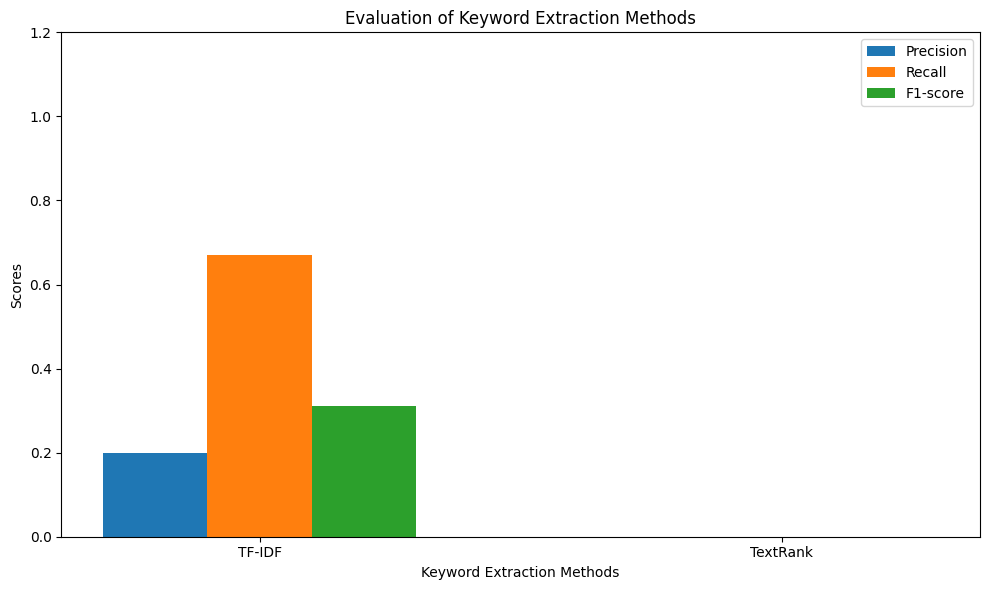

In [21]:
import matplotlib.pyplot as plt

# Example data (replace with actual scores)
methods = ['TF-IDF', 'TextRank']
precision_scores = [0.20, 0.00]
recall_scores = [0.67, 0.0]
f1_scores = [0.31, 0.00]

x = range(len(methods))

plt.figure(figsize=(10, 6))
plt.bar(x, precision_scores, width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], recall_scores, width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.2, label='F1-score')

plt.xlabel('Keyword Extraction Methods')
plt.ylabel('Scores')
plt.title('Evaluation of Keyword Extraction Methods')
plt.xticks([i + 0.2 for i in x], methods)
plt.legend()
plt.ylim(0, 1.2)

plt.tight_layout()
plt.show()
